**Information:** *Some methods to estimate regression parameters that are not weights, select which basis functions to keep in a generalized linear model and to assess the quality of the posterior point-predictive distribution of a regression model*

**Written by:** *Zihao Xu*

**Last updated date:** *Oct.15.2021*

# The evidence approximation

## Motivation

Using Bayesian linear regression we are able to quantify epistemic uncertainty induced by limited data. The method is quite power but we have to pick the precision $\alpha$ of the weights, the measurement noise variance $\sigma^2$ by hand, or any parameters of the basis functions such as the lengthscale $l$ of the radial basis functions. The **evidence approximation** enables us to identify these parameters using the data.

Typically, we call these parameters **hyper-parameters** of the model. For convenience, denote all the hyper-parameter by $\boldsymbol{\varphi}$:
$$
\boldsymbol{\varphi}=\left\{\sigma,\alpha,l,\cdots\right\}
$$

## Definition

Recall the Bayesian linear regression model
$$
\hat{y}=\sum^{n}_{j=1}\theta_j\phi_j(\mathbf{x})=\boldsymbol{\theta}^T\boldsymbol{\phi}(\mathbf{x})
$$
with data likelihood
$$
\mathbf{y}|\mathbf{X},\boldsymbol{\theta},\boldsymbol{\varphi} \sim p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta},\boldsymbol{\varphi}).
$$
The prior of the parameters is
$$
\boldsymbol{\theta}|\boldsymbol{\varphi}\sim p(\boldsymbol{\theta}|\boldsymbol{\varphi}).
$$
Now we have to add a **hyper-prior**
$$
\boldsymbol{\varphi}\sim p(\boldsymbol{\varphi}).
$$
To be fully Bayesian, write down the posterior of everything:
$$
p(\boldsymbol{\theta},\boldsymbol{\varphi}|\mathbf{X},\mathbf{y})\propto p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta},\boldsymbol{\varphi})p(\boldsymbol{\theta}|\boldsymbol{\varphi})p(\boldsymbol{\varphi}).
$$
Look at the marginal posterior of $\boldsymbol{\varphi}$:
$$
p(\boldsymbol{\varphi}|\mathbf{X},\mathbf{y})\propto\int p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta},\boldsymbol{\varphi})p(\boldsymbol{\theta}|\boldsymbol{\varphi})p(\boldsymbol{\varphi})d\boldsymbol{\theta}.
$$
Assume that the hyper-prior is relatively flat:
$$
p(\boldsymbol{\varphi})\propto 1.
$$
Then use a **maximum a posterior** estimate for $\boldsymbol{\theta}$:
$$
\boldsymbol{\varphi}_{\text{MAP}}=\text{arg}\underset{\boldsymbol{\varphi}}{\text{max}}\int p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta},\boldsymbol{\varphi})p(\boldsymbol{\theta}|\boldsymbol{\varphi})d\boldsymbol{\theta}
$$
For **all Gaussian cases** (Gaussian likelihood and prior), the integral on the right-hand-side is analytically available. This is the **evidence approximation** of the hyper-parameters.

## Example

Here is an example where one can estimate the hyper-parameters of Bayesian model using the evidence approximation.

First import some basic libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Ensure reproducibility
np.random.seed(1234)
# Plot setting
sns.set()
sns.set_context('paper')

### Generate the dataset

The synthetic dataset is still generated from a quadratic function
$$
y_i=-0.5+2x_i+2x_i^2+0.1\epsilon_i
$$
where $\epsilon_i\sim \mathcal{N}(0,1)$ and we sample $x_i \sim U([-1,1])$.

Generate this synthetic dataset and visualize the samples.

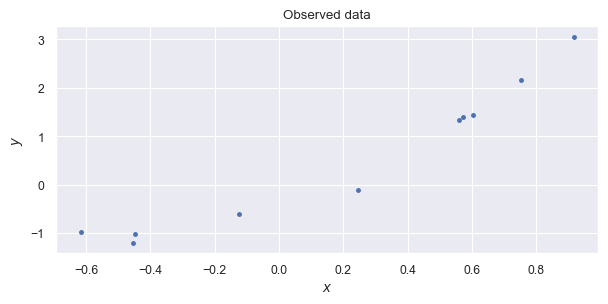

In [2]:
# Number of observations
num_obs = 10
# Sample x
x = (-1.0 + 2 * np.random.rand(num_obs)).reshape(-1, 1)
# True parameters
theta = np.array([-0.5, 2.0, 2.0]).reshape(-1, 1)
sigma = 0.1
# Calculate the corresponding y
y = theta[0] + theta[1] * x + theta[2] * x**2 \
+ sigma * np.random.randn(num_obs).reshape(-1, 1)
# Visualize the dataset
fig, ax = plt.subplots(figsize=(7, 3), dpi=100)
ax.plot(x, y, '.', markersize=5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Observed data')
plt.show()

### The evidence approximation via scikit-learn

The [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge) provides stable implementation of the evidence approximation. It makes some default assumptions about the hyper-priors of $\sigma^2$ and $\alpha$. 

In [3]:
# Scikit-Learn Packages
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
# Select polynomial degree
degree = 3
# Build the model pipeline. Notice the arguments.
# 'include_bias' and 'fit_intercept' should not be both true
estimator = make_pipeline(PolynomialFeatures(degree,include_bias=True),\
BayesianRidge(fit_intercept=False))
# Train the model
model = estimator.fit(x, y.reshape(-1))
# Compare the values
print("The true parameters are:\t", theta.T[0])
# The posterior mean of the weights
m = model[1].coef_
print("The estimated parameters are:\t", m)

The true parameters are:	 [-0.5  2.   2. ]
The estimated parameters are:	 [-0.52041935  2.0310668   1.97934404  0.09835704]


Scikit-learn optimizes the **precision** of the noise, which is the inverse of the variance. Get the $\sigma$ that scikit-learn finds.

In [4]:
sigma = np.sqrt(1.0 / model[1].alpha_)
print('sigma = {0:1.2f}'.format(sigma))

sigma = 0.13


Sklearn optimizes the inverse of our alpha. Get the $\alpha$ that scikit-learn finds.

In [5]:
alpha = np.sqrt(1.0 / model[1].lambda_)
print('alpha = {0:1.2f}'.format(alpha))

alpha = 1.47


The posterior covariance matrix of the weights is also accessible.

In [6]:
S = model[1].sigma_
print(S)

[[ 0.00788226 -0.00462065 -0.02447778  0.0206518 ]
 [-0.00462065  0.03300251  0.02384058 -0.07141947]
 [-0.02447778  0.02384058  0.10621789 -0.10964779]
 [ 0.0206518  -0.07141947 -0.10964779  0.2153479 ]]


### Make predictions separating aleatory and epistemic uncertainty

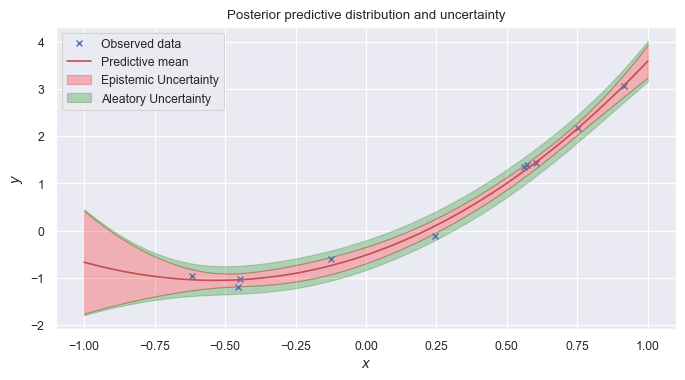

In [7]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
# Some points on which to evaluate the regression function
xe = np.linspace(-1, 1, 100)
# Use the model to get the predictive mean and standard deviation
ye_mean, ye_std_total = model.predict(xe.reshape(-1, 1), return_std=True)
# The epistemic uncertainty
ye_std_epi = np.sqrt(ye_std_total**2 - sigma**2)
# 95% credible interval: Epistemic lower bound and upper bound
ye_lb_epi = ye_mean - 1.96 * ye_std_epi
ye_ub_epi = ye_mean + 1.96 * ye_std_epi
# 95% credible interval: Total uncertainty lower bound and upper bound
ye_lb_total = ye_mean - 1.96 * ye_std_total
ye_ub_total = ye_mean + 1.96 * ye_std_total
# Plot the observations
ax.plot(x, y, 'x', label="Observed data")
# Plot the prediction mean
ax.plot(xe, ye_mean, 'r', label="Predictive mean")
# Plot the epistemic uncertainty induced by limited data
ax.fill_between(xe,ye_lb_epi,ye_ub_epi,\
color="red",alpha=0.25,\
label="Epistemic Uncertainty")
# Plot the aleatory uncertainty induced by measurement noise
ax.fill_between(xe, ye_lb_total, ye_lb_epi,\
color="green", alpha=0.25,\
label="Aleatory Uncertainty")
ax.fill_between(xe, ye_ub_epi, ye_ub_total, color="green", alpha=0.25)
# Set the legend, axis labels and title
ax.set_title("Posterior predictive distribution and uncertainty")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.legend(loc="upper left")
plt.show()

### Get samples from the posterior

Getting samples from the posterior is not implemented in scikit-learn so we have to do it manually.

When constructing the posterior distribution of parameters, it's possible that one get an error because the covariance matrix is singular. Simply add something small to the diagonal will work. The covariance matrix is always positive definite and non-singular, but it may have eigenvalues that are so close to zero that the numerical algorithms find them to be slightly negative, which is an artifact of the floating point precision.

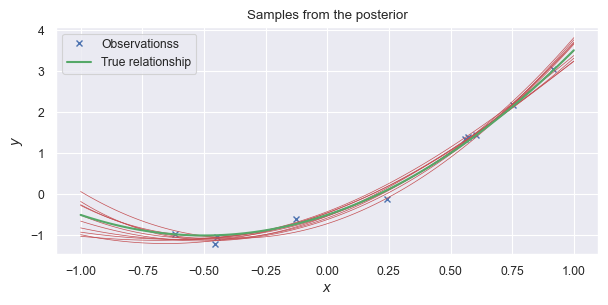

In [8]:
import scipy.stats as st
# Some points on which to evaluate the regression function
xe = np.linspace(-1, 1, 100)
# Get the design matrix
poly = PolynomialFeatures(degree, include_bias=True)
Phi_xe = poly.fit_transform(xe.reshape(-1,1))
# Posterior distribution of weights
theta_post = st.multivariate_normal(mean=m, cov=S)
fig, ax = plt.subplots(figsize=(7, 3), dpi=100)
# Plot the observations
ax.plot(x, y, 'x',label="Observationss")
# Sample from the posterior
for ii in range(10):
    theta_sample = theta_post.rvs()
    ye_sample = np.dot(Phi_xe, theta_sample)
    ax.plot(xe, ye_sample, 'r', lw=0.5)
# Plot the true relationship
ye = theta[0] + theta[1] * xe + theta[2] * xe**2
ax.plot(xe,ye,'g',lw=1.5,label="True relationship")
# Set the axis labels and title
ax.set_title("Samples from the posterior")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.legend(loc="upper left")
plt.show()

%%latex
\newpage

# Automatic relevance determination